In [408]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
%matplotlib inline
def sigmoid(z):
    return 1/(1+np.exp(-z))
def grad_sigmoid(z):
    return np.exp(-z)/(1+np.exp(-z))**2
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)

This is the same as last time, so I'll start it up the same way, but this time with one-hot encoding.

In [146]:
data1 = loadmat('../Data/ex4data1.mat')
y = np.c_[data1['y']]
X = data1['X']
y = ohe.fit_transform(y)

In [149]:
weights = loadmat('../Data/ex4weights.mat')
theta1 = weights['Theta1'].T
theta2 = weights['Theta2'].T
thetas = [theta1, theta2]

In [349]:
def costFunctionNN(X,y,thetas,lamda):
    #expect X to NOT be bias-offset, y to be one-hot encoded, and a list of thetas for each adjacent layer pair
    m = X.shape[0]
    num_layers = len(thetas)+1
    a = []
    a.append(np.c_[np.ones((X.shape[0],1)),X])
    for i in range(1,num_layers):
        a.append(sigmoid(a[i-1]@thetas[i-1]))
        if i<num_layers-1:
            a[i] = np.c_[np.ones((a[i].shape[0],1)),a[i]]
    J = -np.sum(y*np.log(a[num_layers-1])+(1-y)*np.log(1-a[num_layers-1]))/m +\
        lamda*sum([np.sum(theta[1:,:]**2) for theta in thetas])/(2*m)
    return J

In [151]:
costFunctionNN(X,y,thetas,lamda=0)

0.2876291651613189

In [152]:
costFunctionNN(X,y,thetas,lamda=1)

0.384487796242894

The values check out in comparrison with the instructions.

# Now to build a NN from scratch...

In [123]:
theta1.shape

(401, 25)

In [124]:
theta2.shape

(26, 10)

In [417]:
def neuralNetwork(X,y,layers, alpha=.01, lamda=0, iterations=100, gradient_checking=False, activation_function = lambda z:1/(1+np.exp(-z)), grad_activation_function = lambda z:np.exp(-z)/(1+np.exp(-z))**2):
    #expect X to NOT be bias-offset, y to be one-hot encoded, and a list of counts for the number of nodes in each layer
    #i.e. layers[0]=X.shape[1]
    m = X.shape[0]
    L = len(layers)
    #Initialize random thetas
    thetas, regularization_matrix = ([],[])
    for l in range(L-1):
        epsilon = np.sqrt(6/(layers[l]+layers[l+1]))
        thetas.append(epsilon*(2*np.random.rand(layers[l]+1,layers[l+1])-1))
        regularization_matrix.append(np.ones_like(thetas[l]))
        regularization_matrix[l][:,0] = 0
    
    
    J_list = []
    for _ in range(iterations):

        #Initialize Deltas
        Delta = [np.zeros_like(thetas[l]) for l in range(L-1)]

        
        #Forward propogation
        a,z = ([],[[]])
        a.append(np.c_[np.ones((m,1)),X])
        for l in range(1,L):
            z.append(a[l-1]@thetas[l-1])
            a.append(activation_function(z[l]))
            if l<L-1:
                a[l] = np.c_[np.ones((a[l].shape[0],1)),a[l]]

        #compute deltas
        delta = [[] for _ in range(L)] 
        delta[L-1] = a[L-1]-y
        for l in range(L-2,0,-1):
            delta[l] = (delta[l+1]@thetas[l].T)[:,1:]*grad_activation_function(z[l])
        
        #compute Deltas
        for l in range(L-1):
            Delta[l] = a[l].T@delta[l+1]/2
            thetas[l] -= (alpha/m)*(Delta[l]+lamda*thetas[l]*regularization_matrix[l])
        
        J_list.append(costFunctionNN(X=X,y=y,lamda=lamda,thetas=thetas))
        
    if gradient_checking:
        dJbdt = [np.zeros_like(Delta[l]) for l in range(L-1)]
        epsilon = .0001
        for l in range(L-1):
            for i1 in range(thetas[l].shape[0]):
                for i2 in range(thetas[l].shape[1]):
                    tmpTheta = np.copy(thetas)
                    tmpTheta[l][i1,i2] += epsilon
                    plus = costFunctionNN(X=X,y=y,lamda=lamda,thetas=tmpTheta)
                    tmpTheta = np.copy(thetas)
                    tmpTheta[l][i1,i2] -= epsilon
                    minus = costFunctionNN(X=X,y=y,lamda=lamda,thetas=tmpTheta)
                    dJbdt[l][i1,i2] = ((plus-minus)/(2*epsilon))
        return dJbdt, Delta
    else:
        return thetas, J_list

### Testing the gradient

In [419]:
layers = [10,3,4]
m = 40
X = np.random.rand(m,10)
y = np.random.randint(1,5,size=(m,1))
y = ohe.fit_transform(y)
dJbdt, Delta = neuralNetwork(X,y,layers, alpha=1, lamda=0, gradient_checking = True, activation_function=sigmoid, grad_activation_function=grad_sigmoid)
[Delta[l]/dJbdt[l]/m for l in range(len(Delta))]

[array([[0.90983825, 1.03014927, 0.99144507],
        [0.98275364, 0.99563565, 0.9961104 ],
        [1.01311048, 1.01299458, 0.99389323],
        [0.98117765, 0.99245605, 0.99966584],
        [0.9995329 , 0.99245888, 0.99871208],
        [1.00960634, 0.99229359, 1.00739883],
        [0.99287847, 0.99245373, 1.00169166],
        [0.98010544, 0.99524902, 0.99780658],
        [0.97743676, 0.99862425, 0.99477095],
        [1.00375078, 0.9972103 , 0.98850105],
        [0.97412041, 0.96098093, 1.01100248]]),
 array([[1.02775242, 1.19488264, 0.99368209, 0.99342412],
        [0.99604305, 1.00105083, 0.99925013, 0.9996762 ],
        [0.99396933, 0.99173127, 0.67857708, 0.98307631],
        [0.98012908, 0.99211517, 0.99576195, 1.00021441]])]

There's a factor of 2 somewhere that I wasn't prepared for and it held me up for a long time. Maybe it's not in the notes, maybe it's something I did, but it looks like my gradient checks out, so I'm just going to roll with it.

I know the standard is to split the data between a test set and a training set. I have other projects to demonstrate that technique. This project is about building a NN from scratch.

In [420]:
data1 = loadmat('../Data/ex4data1.mat')
y = np.c_[data1['y']]
X = data1['X']
y = ohe.fit_transform(y)
layers = [400, 25, 10]

In [421]:
%%timeit
thetas, J_list = neuralNetwork(X=X, y=y, alpha=1, lamda=1, layers=layers, iterations=5000, activation_function=sigmoid, grad_activation_function=grad_sigmoid)

3min 25s ± 1.45 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


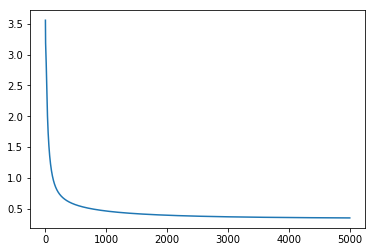

In [422]:
plt.plot(J_list)
plt.show()

I've almost certainly overtrained it at this point, but I mostly wanted to see how far I can push it. 

In [423]:
a2 = sigmoid(np.c_[np.ones((X.shape[0],1)),X]@thetas[0])
a2 = np.c_[np.ones((a2.shape[0],1)),a2]
a3 = sigmoid(a2@thetas[1])
yGuess = a3.argmax(axis=1)
yActual = y.argmax(axis=1)
print(f'The success rate is {100*sum(yGuess==yActual)/yActual.size}%')

The success rate is 98.88%


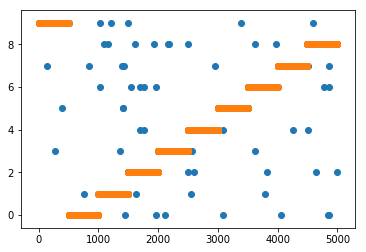

In [445]:
plt.scatter(np.arange(len(yGuess)),yGuess)
plt.scatter(np.arange(len(yGuess)),yActual)
plt.show()

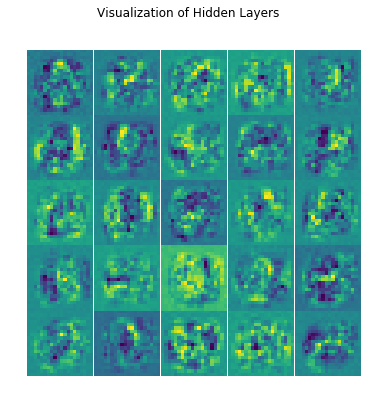

In [435]:
fig, ax = plt.subplots(nrows=5,ncols=5,sharex=True, sharey=True)
fig.set_size_inches(w=6,h=6)
for i1 in range(5):
    for i2 in range(5):
        ax[i1,i2].imshow(thetas[0][1:,i1*5+i2].reshape(20,20))
        ax[i1,i2].set_axis_off()
fig.subplots_adjust(hspace=0,wspace=0)
fig.suptitle('Visualization of Hidden Layers')
plt.show()

You can see a few number-shapes in there. It's also interesting how there's basically no information in the periphery of the frame. That probably means this network could more easily be confused by off-center inputs.

## Now to build a neural net the scikit-learn way.

In [436]:
from sklearn.neural_network import MLPClassifier

In [439]:
clf = MLPClassifier(hidden_layer_sizes=(25,10), activation = 'logistic', solver = 'adam', alpha = .1, max_iter=1000)

In [440]:
clf.fit(X,yActual)

MLPClassifier(activation='logistic', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(25, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [441]:
clf.n_iter_

498

In [442]:
yPredict = clf.predict(X)

In [444]:
print(f'The success rate is {100*sum(yPredict==yActual)/yActual.size}%')

The success rate is 98.6%


So it was far fewer iterations and basically the same success rate as the original.

## Now for a NN the Keras way

Since I went through the trouble of installing Tensorflow

In [446]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [447]:
model = Sequential([
        Dense(400, activation='sigmoid',input_dim=400),
        Dense(25, activation='sigmoid'),
        Dense(10, activation='sigmoid')
        ])
model.compile(optimizer='Adam', loss='mean_squared_error',
                  metrics=['accuracy'])

In [456]:
model.fit(X,y,epochs=1,batch_size=100)

Epoch 1/1
5000/5000 [==============================] - 0s 63us/step - loss: 7.1574e-04 - acc: 0.9954


In [452]:
yKerasPredict = model.predict(X)

In [454]:
yKerasPredict = yKerasPredict.argmax(1)

In [455]:
print(f'The success rate is {100*sum(yKerasPredict==yActual)/yActual.size}%')

The success rate is 99.54%


This number matches the accuracy that the epoch bar predicted. It feels like keras maybe takes a little longer. But it reached crazy high (i.e. overfit) accuracy really fast. And it has good visualization right out of the bag. I like the way Keras allows you to build any kind of NN piece by piece in a really obvious way. It will probably be my NN choice going forward.